In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.rcParams['figure.figsize'] = [16, 8]
cmap = plt.cm.get_cmap('brg', 3)

In [2]:
data_all = pd.read_csv('data/doi_10.5061_dryad.zcrjdfn81__v2/Acou_data_13-18.txt', sep='\t')
data_all['DateTime'] = pd.to_datetime(data_all['DateTime'])

In [3]:
data_all[['ID', 'DateTime']].groupby('ID').apply(lambda x: x.max() - x.min())

,DateTime
ID,
Acou/MM1,1 days 07:27:01
Acou/MM10,2 days 15:28:27
Acou/MM11,8 days 02:50:24
Acou/MM12,6 days 05:39:10
Acou/MM13,8 days 01:22:29
Acou/MM14,4 days 15:11:45
Acou/MM15,4 days 06:47:30
Acou/MM16,4 days 06:15:54
Acou/MM2,0 days 01:00:54


In [129]:
data = data_all[data_all['ID'] == 'Acou/MM1']
data

,ID,DateTime,Depth,Buzz,temperatureCorrected
0,Acou/MM1,2013-08-10 05:27:59,-2.755978,0.0,4.651308
1,Acou/MM1,2013-08-10 05:28:00,-3.298893,0.0,4.656611
2,Acou/MM1,2013-08-10 05:28:01,-3.929375,0.0,4.655065
3,Acou/MM1,2013-08-10 05:28:02,-4.554020,0.0,4.645064
4,Acou/MM1,2013-08-10 05:28:03,-5.061909,0.0,4.658837
...,...,...,...,...,...
113217,Acou/MM1,2013-08-11 12:54:56,1.301293,0.0,6.162202
113218,Acou/MM1,2013-08-11 12:54:57,1.412212,0.0,6.154559
113219,Acou/MM1,2013-08-11 12:54:58,1.330482,0.0,6.121719
113220,Acou/MM1,2013-08-11 12:54:59,1.371347,0.0,6.114716


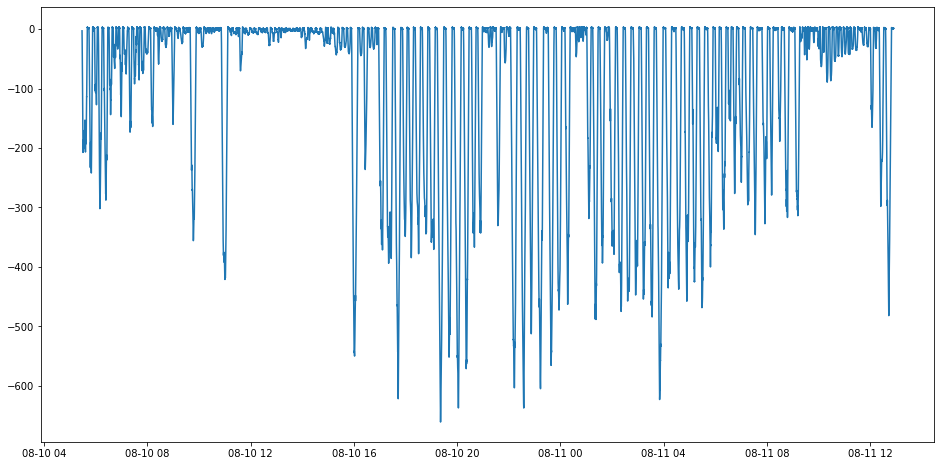

In [130]:
plt.plot(data['DateTime'], data['Depth'])

In [131]:
data_diff = data[['DateTime']][:-1]
data_diff['Depth'] = np.diff(data['Depth'])

How to identify dives:
- A dive starts and stops approximately a the same hight close to data['Depth'].max()
- A dive is not part of a bigger dive
- Idea definition: a dive is a max1-min1-max2 triple with abs(max1 - max2) < min(max1-min1, max2-min2), i.e. the depth of a dive is bigger than the difference between the starting and end point

In [276]:
filter_max = (data['Depth'][:-2].values < data['Depth'][1:-1].values) \
    & (data['Depth'][1:-1].values >= data['Depth'][2:].values)
filter_max = np.insert(filter_max, 0, False)  # padding
filter_max = np.append(filter_max, False)

filter_min = (data['Depth'][:-2].values >= data['Depth'][1:-1].values) \
    & (data['Depth'][1:-1].values < data['Depth'][2:].values)
filter_min = np.insert(filter_min, 0, False)  # padding
filter_min = np.append(filter_min, False)

filter_min[:np.where(filter_max)[0].min()] = False  # make sure we start and end with a max
filter_min[np.where(filter_max)[0].max():] = False

In [277]:
# Nr triples:
sum(filter_min)

11442

In [278]:
# sanity check: are there 2 min without a max in between or vice versa?
# if everything went right this should yield [0, 1] (because we start with a max)
np.unique((1*filter_max - 1*filter_min).cumsum())

array([0, 1])

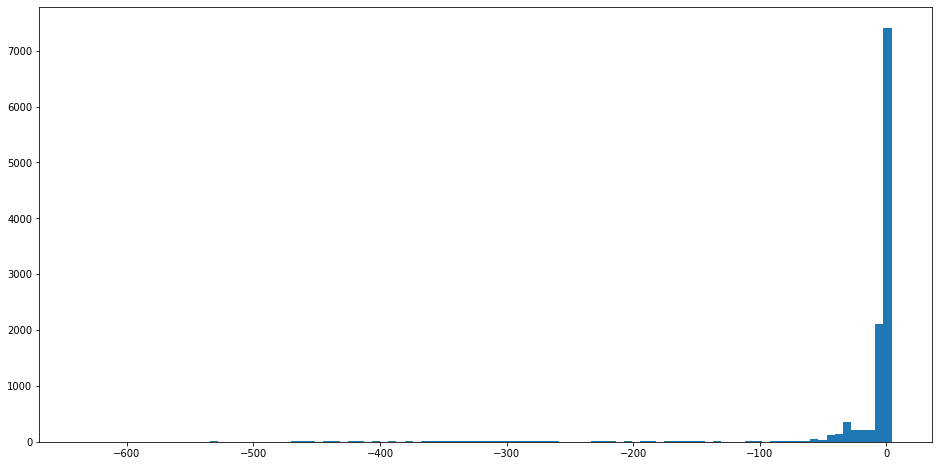

In [279]:
plt.hist(data['Depth'][filter_max], 100)
pass

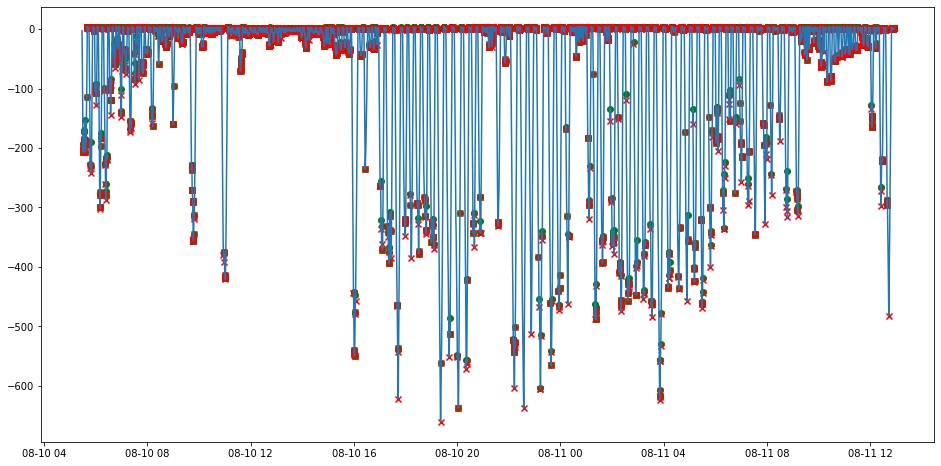

In [280]:
plt.plot(data['DateTime'], data['Depth'])
plt.scatter(data['DateTime'][filter_max], data['Depth'][filter_max], marker='o', c='green')
plt.scatter(data['DateTime'][filter_min], data['Depth'][filter_min], marker='x', c='red')

(-13.0, 4.0)

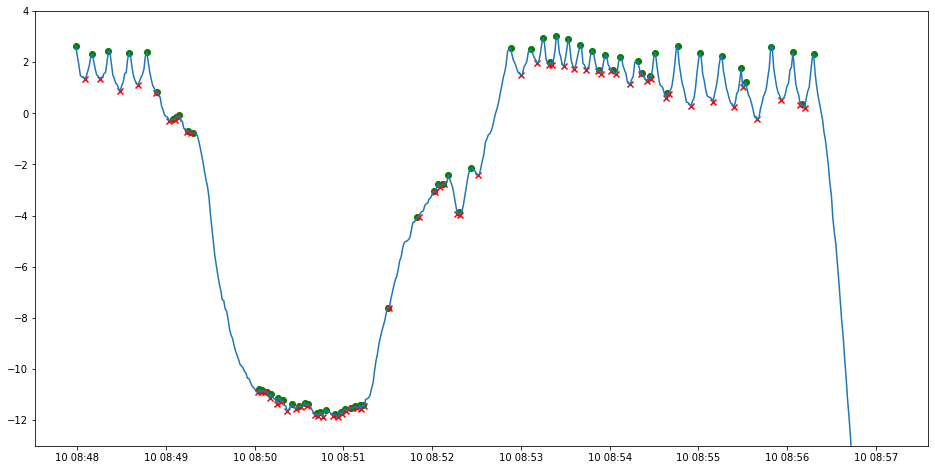

In [281]:
start = 12000
stop = start + 550
plt.plot(data['DateTime'][start:stop], data['Depth'][start:stop])
plt.scatter(
    data['DateTime'][start:stop][filter_max[start:stop]], 
    data['Depth'][start:stop][filter_max[start:stop]],
    marker='o',
    c='green'
)
plt.scatter(
    data['DateTime'][start:stop][filter_min[start:stop]], 
    data['Depth'][start:stop][filter_min[start:stop]],
    marker='x',
    c='red'
)
plt.ylim(-13, 4)

(1.0, 4.0)

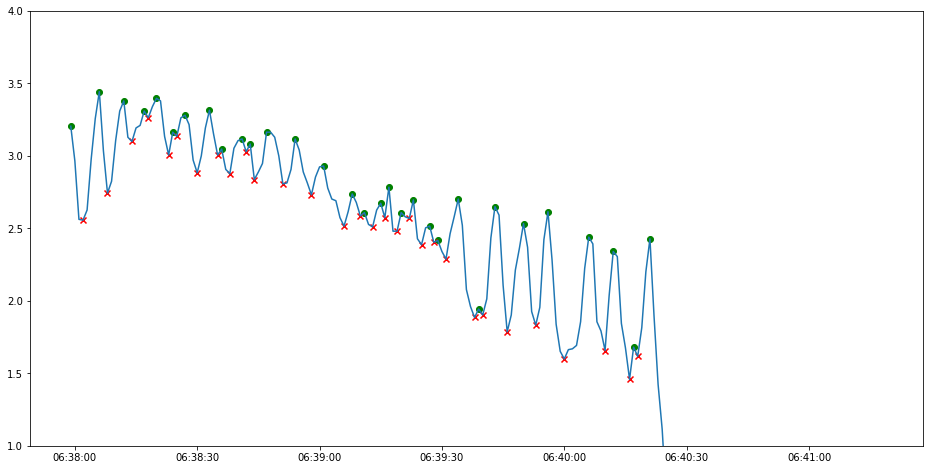

In [282]:
start = 4200
stop = start + 200
plt.plot(data['DateTime'][start:stop], data['Depth'][start:stop])
plt.scatter(
    data['DateTime'][start:stop][filter_max[start:stop]], 
    data['Depth'][start:stop][filter_max[start:stop]],
    marker='o',
    c='green'
)
plt.scatter(
    data['DateTime'][start:stop][filter_min[start:stop]], 
    data['Depth'][start:stop][filter_min[start:stop]],
    marker='x',
    c='red'
)
plt.ylim(1, 4)

Text(0.5, 0, 'Depth of the dive: min(max1-min1, max2-min2)')

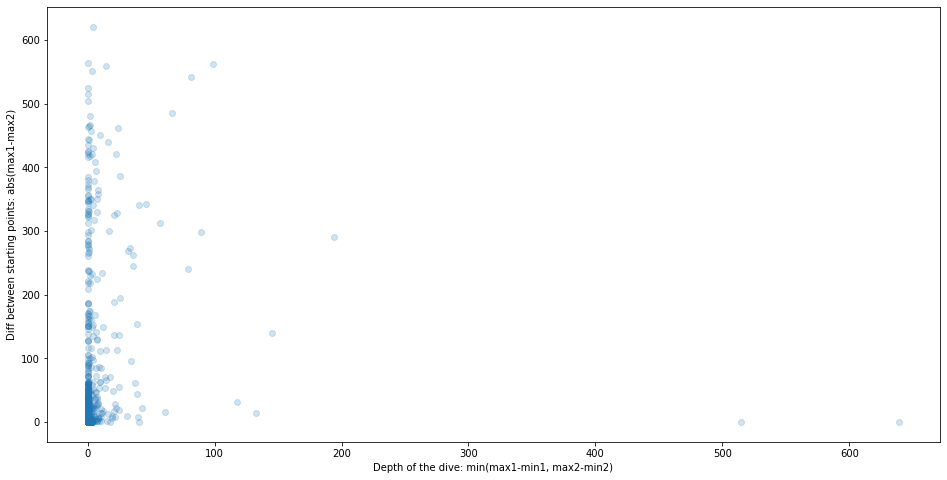

In [283]:
plt.scatter(
    np.minimum(
        data['Depth'][filter_max][:-1].values - data['Depth'][filter_min].values,
        data['Depth'][filter_max][1:].values - data['Depth'][filter_min].values
    ),
    abs(np.diff(data['Depth'][filter_max])), 
    alpha=0.2
)
plt.ylabel('Diff between starting points: abs(max1-max2)')
plt.xlabel('Depth of the dive: min(max1-min1, max2-min2)')

In [284]:
while True:
    triple_depth = np.minimum(
        data['Depth'][filter_max][:-1].values - data['Depth'][filter_min].values,
        data['Depth'][filter_max][1:].values - data['Depth'][filter_min].values
    )
    triple_diff = abs(data['Depth'][filter_max][:-1].values - data['Depth'][filter_max][1:].values)
    smaller_max = np.where(
        data['Depth'][filter_max][:-1].values < data['Depth'][filter_max][1:].values, 
        np.where(filter_max)[0][:-1], np.where(filter_max)[0][1:]
    )

    triple_bad = triple_depth < triple_diff
    print('Nr bad triples: ', sum(triple_bad))
    if not sum(triple_bad):
        break

    filter_max[smaller_max[triple_bad]] = False  # remove smaller max of non-dives

    # fuse mins where there are multiple in a row:
    triple_groups = np.split(np.arange(filter_max.shape[0]), np.where(filter_max)[0])
    smallest_mins = np.array([min(tg, key=lambda t: data['Depth'][t]) for tg in triple_groups])
    filter_min[:] = False
    filter_min[smallest_mins] = True

    filter_min[:np.where(filter_max)[0].min()] = False  # make sure we start and end with a max
    filter_min[np.where(filter_max)[0].max():] = False

Nr bad triples:  6697
Nr bad triples:  1188
Nr bad triples:  498
Nr bad triples:  264
Nr bad triples:  157
Nr bad triples:  103
Nr bad triples:  70
Nr bad triples:  55
Nr bad triples:  40
Nr bad triples:  32
Nr bad triples:  31
Nr bad triples:  26
Nr bad triples:  18
Nr bad triples:  17
Nr bad triples:  17
Nr bad triples:  14
Nr bad triples:  14
Nr bad triples:  13
Nr bad triples:  10
Nr bad triples:  8
Nr bad triples:  8
Nr bad triples:  8
Nr bad triples:  7
Nr bad triples:  4
Nr bad triples:  3
Nr bad triples:  3
Nr bad triples:  3
Nr bad triples:  3
Nr bad triples:  3
Nr bad triples:  2
Nr bad triples:  2
Nr bad triples:  1
Nr bad triples:  1
Nr bad triples:  0


In [285]:
# Nr triples:
sum(filter_min)

3673

In [286]:
# sanity check: are there 2 min without a max in between or vice versa?
# if everything went right this should yield [0, 1] (because we start with a max)
np.unique((1*filter_max - 1*filter_min).cumsum())

array([0, 1])

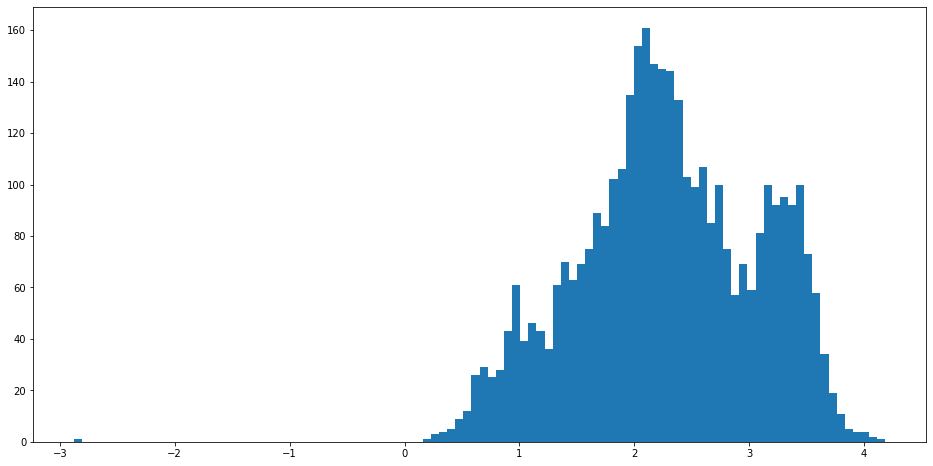

In [287]:
plt.hist(data['Depth'][filter_max], 100)
pass

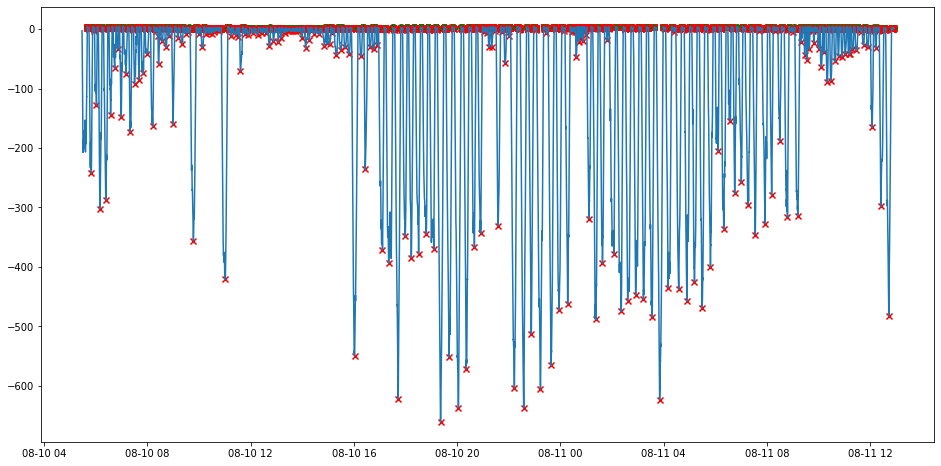

In [288]:
plt.plot(data['DateTime'], data['Depth'])
plt.scatter(data['DateTime'][filter_max], data['Depth'][filter_max], marker='o', c='green')
plt.scatter(data['DateTime'][filter_min], data['Depth'][filter_min], marker='x', c='red')

(-13.0, 4.0)

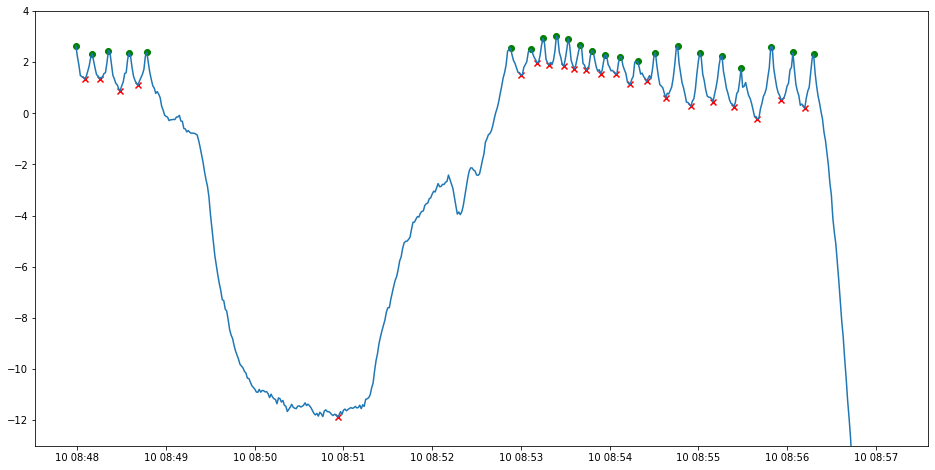

In [289]:
start = 12000
stop = start + 550
plt.plot(data['DateTime'][start:stop], data['Depth'][start:stop])
plt.scatter(
    data['DateTime'][start:stop][filter_max[start:stop]], 
    data['Depth'][start:stop][filter_max[start:stop]],
    marker='o',
    c='green'
)
plt.scatter(
    data['DateTime'][start:stop][filter_min[start:stop]], 
    data['Depth'][start:stop][filter_min[start:stop]],
    marker='x',
    c='red'
)
plt.ylim(-13, 4)

(1.0, 4.0)

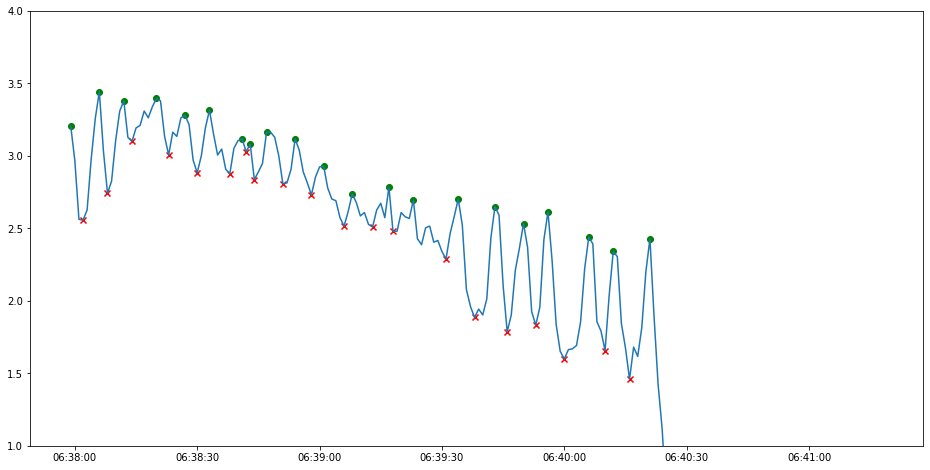

In [290]:
start = 4200
stop = start + 200
plt.plot(data['DateTime'][start:stop], data['Depth'][start:stop])
plt.scatter(
    data['DateTime'][start:stop][filter_max[start:stop]], 
    data['Depth'][start:stop][filter_max[start:stop]],
    marker='o',
    c='green'
)
plt.scatter(
    data['DateTime'][start:stop][filter_min[start:stop]], 
    data['Depth'][start:stop][filter_min[start:stop]],
    marker='x',
    c='red'
)
plt.ylim(1, 4)

Text(0.5, 0, 'Depth of the dive: min(max1-min1, max2-min2)')

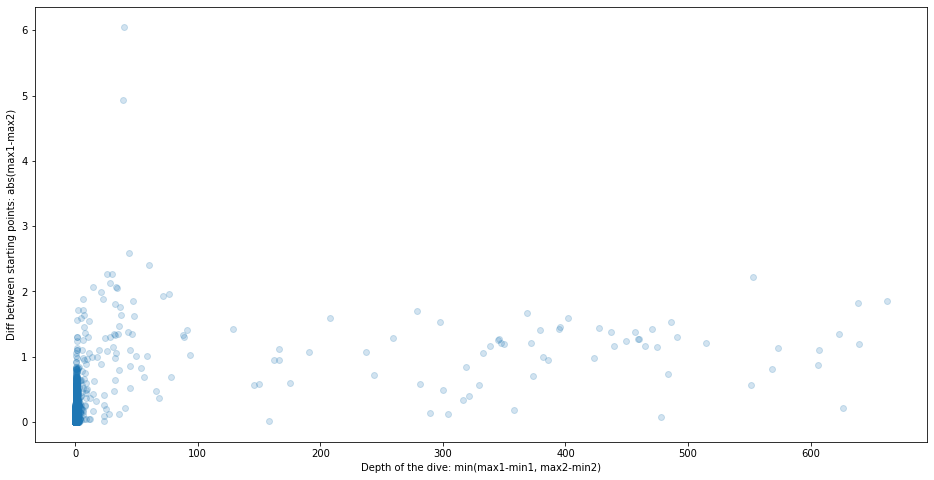

In [291]:
plt.scatter(
    np.minimum(
        data['Depth'][filter_max][:-1].values - data['Depth'][filter_min].values,
        data['Depth'][filter_max][1:].values - data['Depth'][filter_min].values
    ),
    abs(np.diff(data['Depth'][filter_max])), 
    alpha=0.2
)
plt.ylabel('Diff between starting points: abs(max1-max2)')
plt.xlabel('Depth of the dive: min(max1-min1, max2-min2)')

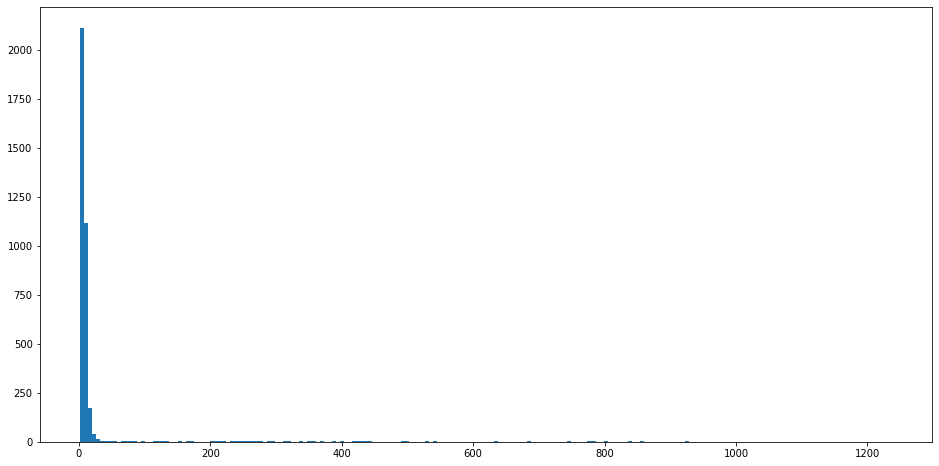

In [302]:
# distribution of dive length in seconds
plt.hist(np.diff(np.where(filter_max)[0]), 200)
pass

In [325]:
# 90% of the curves are shorter than 16 seconds
sum(np.diff(np.where(filter_max)[0]) <= 16) / sum(filter_min)

0.906071331336782

In [327]:
# 0%, 5%, 10%, ... , 95%, 100% quantiles
np.quantile(np.diff(np.where(filter_max)[0]), np.arange(21)/20)

array([   2. ,    3. ,    4. ,    4. ,    5. ,    6. ,    6. ,    7. ,
          7. ,    7. ,    8. ,    8. ,    9. ,    9. ,   10. ,   11. ,
         12. ,   13. ,   16. ,  105.8, 1237. ])